In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from scipy.stats import norm
import os
pi = np.pi

In [2]:
# make grid of tangent projection centers - every 10 deg

alphasdeg = np.linspace(90,-90,19) # elevation
alphas = np.multiply(pi/180,alphasdeg)
thetasdeg = np.linspace(-180,180,36,endpoint=False)# azimuth
thetas = np.multiply(pi/180,thetasdeg)

# make local points and handle reprojection to different locations 

def makegrid(fovdeg=10,res=10,f=1.0):
    xlim = f*np.tan(fovdeg/2 * pi/180)
    xx,yy = np.meshgrid(np.linspace(-xlim,xlim,res),np.linspace(-xlim,xlim,res))
    return xx,yy

xx,yy = makegrid(fovdeg=10,res=10)
xx = np.ndarray.flatten(xx)
yy = np.ndarray.flatten(yy)

def pitch(a):
    return np.array([[1,0,0],[0,np.cos(a),np.sin(a)],[0,-np.sin(a),np.cos(a)]])

def yaw(a):
    return np.array([[np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]])

def roll(a):
    return np.array([[np.cos(a),-np.sin(a),0],[np.sin(a),np.cos(a),0],[0,0,1]])

def makeR(theta,alpha=0,gamma=0):
    return np.matmul(np.matmul(roll(gamma),pitch(alpha)),yaw(theta))

In [3]:
# create flows for different velocities and geometries

# geometries
def nearness_local(geometry='sphere',x=xx,y=yy,r=1,alpha=0):
    if geometry == 'sphere':
        mu = 1/r*np.sqrt(1-(x**2+y**2))
    elif geometry == 'floor':
        #mu = np.abs(np.sin(alpha))/r * (alpha < 0)
        mu = np.abs(np.sin(y+alpha))/r * (y+alpha < 0)
    return mu

# flow from velocity
def getflow_local(Vx=0,Vy=0,Vz=0,Wx=0,Wy=0,Wz=0,
              geometry='sphere',r=1,f=1,
              x=xx,y=yy,theta=0,alpha=0):
    
    # rotate velocity to local patch
    V0 = [[Vx,Vy,Vz],[Wx,Wy,Wz]]
    R = makeR(theta,alpha)
    V = np.transpose(np.matmul(R,np.transpose(V0)))
    Vx,Vy,Vz = V[0]
    Wx,Wy,Wz = V[1]
    
    # get nearness
    mu = nearness_local(geometry=geometry,x=x,y=y,r=r,alpha=alpha)
    
    # compute local flow
    flow_horiz = -Vx*f*mu + Vz*mu*x - Wx*x*y/f + Wy*(f**2+x**2)/f - Wz*y
    flow_vert = -Vy*f*mu + Vz*mu*y - Wx*(f**2+y**2)/f + Wy*x*y/f + Wz*x
    
    return flow_horiz,flow_vert  

In [4]:
# predict self motion velocity from local flow patch
def getvel_local(flow,theta=0,alpha=0,x=xx,y=yy,geometry='sphere',DOFs=6,weights=np.ones_like(xx)):
    
    vxtemplate = np.ndarray.flatten(np.array(getflow_local(Vx=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    vytemplate = np.ndarray.flatten(np.array(getflow_local(Vy=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    vztemplate = np.ndarray.flatten(np.array(getflow_local(Vz=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    wxtemplate = np.ndarray.flatten(np.array(getflow_local(Wx=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    wytemplate = np.ndarray.flatten(np.array(getflow_local(Wy=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    wztemplate = np.ndarray.flatten(np.array(getflow_local(Wz=1,theta=theta,alpha=alpha,geometry=geometry,x=x,y=y)))
    
    if DOFs == 1:
        templates = vztemplate
    elif DOFs == 3:
        templates = np.stack([vxtemplate,vztemplate,wytemplate])
    elif DOFs == 6:
        templates = np.stack([vxtemplate,vytemplate,vztemplate,wxtemplate,wytemplate,wztemplate])
    
    # remove locations where flow is missing
    weights = np.copy(weights)
    weights[np.isnan(flow[0])] = 0
    weights[np.isnan(flow[1])] = 0
    flow[0][np.isnan(flow[0])] = 0
    flow[1][np.isnan(flow[1])] = 0
    
    # weight template and sample
    template = np.transpose(templates*np.tile(weights,[DOFs,2]))
    sample = np.transpose(np.ndarray.flatten(np.array(flow))*np.tile(weights,[1,2]))
    
    # solve for self motion
    pred,_,_,_ = np.linalg.lstsq(template,sample,rcond=-1)
    return np.squeeze(pred)


# angle difference for heading error`
def anglediff(a,b,deg=False):
    if deg:
        return np.arctan2(np.sin((a-b)*np.pi/180),np.cos((a-b)*np.pi/180))*180/np.pi
    else:
        return np.arctan2(np.sin(a-b),np.cos(a-b))

In [5]:
# characterize local errors
def getlocalerrs(theta=0,alpha=0,
                 x=xx,y=yy,
                 trials=10000,
                 noiselevel=0.1,
                 spatvarnoise=False,
                 sparselevel=.25,
                 geometry='sphere',
                 DOFs=6,
                 plotit=False):

    errs = np.nan*np.ones([trials,DOFs+1])
    
    for i in range(trials): 
        
        # generate random behavior (uniform from -1 to 1)
        Vx,Vy,Vz,Wx,Wy,Wz = 2*np.random.rand(6) - 1
        if DOFs == 3:
            Vy = Wx = Wz = 0
        elif DOFs == 1:
            Vx = Vy = Wx = Wy = Wz = 0
            
        # create clean flow
        flow = getflow_local(geometry=geometry,theta=theta,alpha=alpha,x=x,y=y,
                         Vx=Vx,Vy=Vy,Vz=Vz,Wx=Wx,Wy=Wy,Wz=Wz)
        # add noise
        _,h = np.shape(flow)
        noise = noiselevel*np.random.randn(2*h)
        noise = np.reshape(noise,[2,h])
        if spatvarnoise:
            #noise = noise*(-(np.tile(y+alpha,[2,1])+np.pi/2)/(np.pi))
            noise = noise*((np.tile(-(y+alpha),[2,1])+np.pi/2)/(np.pi))
        flow = flow + noise

        # make sparse
        sparsity = np.random.rand(h)
        flow[0][sparsity<sparselevel] = np.nan
        flow[1][sparsity<sparselevel] = np.nan
        
        # optionally, plot flows
        if plotit == True:
            plt.quiver(x,y,flow[0],flow[1],scale=10,color='r')
            plt.xlim(-np.pi,np.pi)
            plt.ylim(-np.pi/2 - 0.25,np.pi/2 + 0.25)
            plt.savefig(f'./plots/example_local_flow_{i}.eps', format='eps')

        # get prediction and errors
        preds = getvel_local(flow,geometry=geometry,theta=theta,alpha=alpha,x=x,y=y,DOFs=DOFs)
        if DOFs == 3:
            gt =  [Vx,Vz,Wy]
        elif DOFs == 1:
            gt = [Vz]
        else:
            gt = [Vx,Vy,Vz,Wx,Wy,Wz]
        errs[i,:DOFs] = preds-gt
    
        # heading error
        if DOFs == 6:
            headinggt = np.arctan2(gt[0],gt[2])
            headingpred = np.arctan2(preds[0],preds[2])
            headingerr = anglediff(headingpred,headinggt,deg=False)
            errs[i,-1] = headingerr
        elif DOFs == 3:
            headinggt = np.arctan2(gt[0],gt[1])
            headingpred = np.arctan2(preds[0],preds[1])
            headingerr = anglediff(headingpred,headinggt,deg=False)
            errs[i,-1] = headingerr

    return errs

In [6]:
# run sim a bunch of times
def error_distribution(repeats=10,trials=10,noiselevel=0.25,sparselevel=.667,geometry='sphere',theta=thetas,alpha=alphas,behaviorDOFs=6,plotit=False,spatvarnoise=False):

    # initialize results        
    all_err         = np.zeros([repeats,7])

    for i in range(repeats):

        errs = getlocalerrs(theta=theta,alpha=alpha,
                                    trials=trials,
                                    noiselevel=noiselevel,
                                    spatvarnoise=spatvarnoise,
                                    sparselevel=sparselevel,
                                    geometry=geometry,
                                    DOFs=behaviorDOFs)
        errs = np.nanmedian(np.abs(errs),axis=0)

        if behaviorDOFs == 6:
            all_err[i,:] = errs
        elif behaviorDOFs == 1:
            all_err[i,2] = errs[0]
        elif behaviorDOFs == 3:
            all_err[i,0] = errs[0]
            all_err[i,2] = errs[1]
            all_err[i,4] = errs[2]
            all_err[i,6] = errs[3]
                
    return all_err


In [7]:
# calculate median error a bunch of times at best, worst, and middle patch for 6DOF sphere
def prep_histograms(trials=10,repeats=10,behaviorDOFs=6,geometry='sphere',spatvarnoise=False,component='Vz'):
    
    # load data file with median error at each location
    if spatvarnoise:
        data = np.load(f'./local_median_error_files/local_67pctsparse_10000trials_0.25noise_spatvarnoise_{geometry}_{behaviorDOFs}DOFs_median_errors.npz')
    else:
        data = np.load(f'./local_median_error_files/local_67pctsparse_10000trials_0.25noise_{geometry}_{behaviorDOFs}DOFs_median_errors.npz')

        
    if component == 'heading':
        median_error = data['median_error_heading']
    elif component == 'Vz':
        median_error = data['median_error_Vz']
    else:
        print('invalid component')
        
    # get indices
    best_ind = np.where(median_error == np.min(median_error))
    worst_ind = np.where(median_error == np.max(median_error))
    middle_ind = np.where(median_error == np.median(median_error))

    # deal with duplicates
    if np.size(best_ind) > 2:
        best_ind = best_ind[0]

    if np.size(worst_ind) > 2:
        worst_ind = worst_ind[0]

    if np.size(middle_ind) > 2:
        middle_ind = middle_ind[0]

    best_theta = thetas[best_ind[1]]
    best_alpha = alphas[best_ind[0]]

    worst_theta = thetas[worst_ind[1]]
    worst_alpha = alphas[worst_ind[0]]

    middle_theta = thetas[middle_ind[1]]
    middle_alpha = alphas[middle_ind[0]]

    print('best: alpha =', best_alpha, ' theta =',best_theta)
    print('middle: alpha =', middle_alpha, ' theta =',middle_theta)
    print('worst: alpha =', worst_alpha, ' theta =',worst_theta)
    
    # calculate median error a bunch of times at best, worst, and middle patch for 6DOF sphere
    errs_best = error_distribution(repeats=repeats,trials=trials,noiselevel=0.25,
                                        sparselevel=.667,
                                        geometry=geometry,
                                        theta=best_theta,alpha=best_alpha,
                                        behaviorDOFs=behaviorDOFs,
                                        spatvarnoise=spatvarnoise)

    errs_worst = error_distribution(repeats=repeats,trials=trials,noiselevel=0.25,
                                        sparselevel=.667,
                                        geometry=geometry,
                                        theta=worst_theta,alpha=worst_alpha,
                                        behaviorDOFs=behaviorDOFs,
                                        spatvarnoise=spatvarnoise)

    errs_middle = error_distribution(repeats=repeats,trials=trials,noiselevel=0.25,
                                        sparselevel=.667,
                                        geometry=geometry,
                                        theta=middle_theta,alpha=middle_alpha,
                                        behaviorDOFs=behaviorDOFs,
                                        spatvarnoise=spatvarnoise)

    # convert to cm/s
    errs_best[0:2] = 100*errs_best[0:2] # convert to cm
    errs_best[3:] = (180/np.pi)*errs_best[3:] # convert to deg
    
    errs_worst[0:2] = 100*errs_worst[0:2] # convert to cm
    errs_worst[3:] = (180/np.pi)*errs_worst[3:] # convert to deg
    
    errs_middle[0:2] = 100*errs_middle[0:2] # convert to cm
    errs_middle[3:] = (180/np.pi)*errs_middle[3:] # convert to deg

    if spatvarnoise:
        np.savez(f'./local_median_error_files/histogram_median_errors_Fig2_{DOFs}DOF_{geometry}_{component}_spatiallyvaryingnoise.npz',errs_best=errs_best,errs_worst=errs_worst,errs_middle=errs_middle)
    else:
        np.savez(f'./local_median_error_files/histogram_median_errors_Fig2_{DOFs}DOF_{geometry}_{component}.npz',errs_best=errs_best,errs_worst=errs_worst,errs_middle=errs_middle)

    

In [ ]:
trials=1000
repeats=1000

# 1DOF sphere
geometry = 'sphere'
DOFs = 1
spatvarnoise = False
component = 'Vz'

print('1DOF sphere')
prep_histograms(trials=trials,repeats=repeats,behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


# 3DOF sphere
geometry = 'sphere'
DOFs = 3
spatvarnoise = False
component = 'Vz'

print('3DOF sphere')
prep_histograms(trials=trials,repeats=repeats,behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


# 3DOF sphere - spatially varying noise
geometry = 'sphere'
DOFs = 3
spatvarnoise = True
component = 'Vz'

print('3DOF sphere - spatially varying noise')
prep_histograms(trials=trials,repeats=repeats,behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


# 3DOF floor
geometry = 'floor'
DOFs = 3
spatvarnoise = False
component = 'Vz'

print('3DOF floor Vz')
prep_histograms(trials=trials,repeats=repeats,behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)

component = 'heading'

print('3DOF floor heading')
prep_histograms(trials=trials,repeats=repeats,behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


In [8]:
trials=1000
repeats=1000

# 3DOF floor
geometry = 'floor'
DOFs = 3
spatvarnoise = False
component = 'Vz'

#print('3DOF floor Vz')
#prep_histograms(trials=trials,repeats=repeats,behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)

component = 'heading'

print('3DOF floor heading')
prep_histograms(trials=trials,repeats=repeats,behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)


3DOF floor heading
best: alpha = [-1.57079633]  theta = [-0.17453293]
middle: alpha = [0.]  theta = [0.52359878]
worst: alpha = [0.87266463]  theta = [-1.91986218]


/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/1043166322.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[1,0,0],[0,np.cos(a),np.sin(a)],[0,-np.sin(a),np.cos(a)]])
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/1043166322.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([[np.cos(a),0,np.sin(a)],[0,1,0],[-np.sin(a),0,np.cos(a)]])


In [ ]:
data = np.load(f'./local_median_error_files/histogram_median_errors_Fig2_3DOF_floor_heading.npz')
errs_best = data['errs_best']
errs_worst = data['errs_worst']
errs_middle = data['errs_middle']
plt.hist(errs_worst[:,6],color='orange')
plt.hist(errs_middle[:,6],color='black')

In [34]:
os.makedirs('./plots/',exist_ok=True)
os.makedirs('./final_plots/',exist_ok=True)

def plot_histograms(behaviorDOFs=6,geometry='sphere',spatvarnoise=False,component='Vz'):
    

    if spatvarnoise:
        data = np.load(f'./local_median_error_files/histogram_median_errors_Fig2_{DOFs}DOF_{geometry}_{component}_spatiallyvaryingnoise.npz')
    else:
        data = np.load(f'./local_median_error_files/histogram_median_errors_Fig2_{DOFs}DOF_{geometry}_{component}.npz')

    
    errs_best = data['errs_best']
    errs_worst = data['errs_worst']
    errs_middle = data['errs_middle']

    errs_best = np.log(errs_best)
    errs_worst = np.log(errs_worst)
    errs_middle = np.log(errs_middle)

    font = {'family' : 'arial',
             'size'   : 6}

    matplotlib.rc('font', **font)

    if component == 'Vz':
        comp_ind = 2
    elif component == 'heading':
        comp_ind = 6
        
    # bounds
    print('best min LOG ERROR',np.min(errs_best[:,comp_ind]))
    print('worst max LOG ERROR',np.max(errs_worst[:,comp_ind]))

    # set sensible ranges
    if DOFs == 1:
        xmin = -1
        xmax = 6.5
    elif DOFs == 3:
        xmin = -6
        xmax = 6.5
        
        if spatvarnoise==False:
            xmin = -1
            xmax = 6.5

        if geometry=='floor':
            
            if component == 'heading':
                xmin = 0
                xmax = 5
            else:
                xmin = -0.75
                xmax = 5

            
    x = np.linspace(xmin, xmax, 100)
    
    # remove outliers for fitting
    errs_best = errs_best[np.logical_and(errs_best[:,comp_ind] > np.percentile(errs_best[:,comp_ind],1),errs_best[:,comp_ind] < np.percentile(errs_best[:,comp_ind],99)),:]
    errs_worst = errs_worst[np.logical_and(errs_worst[:,comp_ind] > np.percentile(errs_worst[:,comp_ind],1),errs_worst[:,comp_ind] < np.percentile(errs_worst[:,comp_ind],99)),:]
    errs_middle = errs_middle[np.logical_and(errs_middle[:,comp_ind] > np.percentile(errs_middle[:,comp_ind],1),errs_middle[:,comp_ind] < np.percentile(errs_middle[:,comp_ind],99)),:]

    plt.figure(figsize=(.8,.8))

    plt.hist(errs_best[:,comp_ind],bins=x,label='best',alpha=0.5,density=True,color='green')
    mu_best, std_best = norm.fit(errs_best[:,comp_ind])
    p = norm.pdf(x, mu_best, std_best)
    plt.plot(x, p, 'green', linewidth=2)

    plt.hist(errs_worst[:,comp_ind],bins=x,label='worst',alpha=0.5,density=True,color='orange')
    mu_worst, std_worst = norm.fit(errs_worst[:,comp_ind])
    p = norm.pdf(x, mu_worst, std_worst)
    plt.plot(x, p, 'orange', linewidth=2)

    plt.hist(errs_middle[:,comp_ind],bins=x,label='middle',alpha=0.5,density=True,color='k')
    mu_middle, std_middle = norm.fit(errs_middle[:,comp_ind])
    p = norm.pdf(x, mu_middle, std_middle)
    plt.plot(x, p, 'k', linewidth=2)

    #plt.legend(prop={'size': 6})
    if component == 'Vz':
        plt.xlabel('median error (LOG cm/s)')
    elif component == 'heading':
        plt.xlabel('median error (LOG deg)')
    #plt.ylabel('probability density')
    plt.yticks([])
    
    plt.xlim(xmin,xmax)
    plt.xticks(np.linspace(xmin,xmax,4))
    
    # dprimes
    print('effect size (D) best to middle',(mu_best-mu_middle)/np.sqrt((np.std(errs_best[:,comp_ind], ddof=1) ** 2 + np.std(errs_middle[:,comp_ind], ddof=1) ** 2) / 2.0) )
    print('effect size (D) worst to middle',(mu_worst-mu_middle)/np.sqrt((np.std(errs_worst[:,comp_ind], ddof=1) ** 2 + np.std(errs_middle[:,comp_ind], ddof=1) ** 2) / 2.0) )

    if spatvarnoise:
        plt.savefig(f'./final_plots/final_fig2_local_histogram_{component}_{geometry}_{DOFs}DOF_spatiallyvaryingnoise.png', format='png',dpi=300)
        plt.savefig(f'./final_plots/final_fig2_local_histogram_{component}_{geometry}_{DOFs}DOF_spatiallyvaryingnoise.eps', format='eps',dpi=300)
      
    else:
        plt.savefig(f'./final_plots/final_fig2_local_histogram_{component}_{geometry}_{DOFs}DOF.png', format='png',dpi=300)
        plt.savefig(f'./final_plots/final_fig2_local_histogram_{component}_{geometry}_{DOFs}DOF.eps', format='eps',dpi=300)

    

1DOF sphere
best min LOG ERROR -3.4950223135085334
worst max LOG ERROR 4.588374433099032
effect size (D) best to middle -87.31810518901587
effect size (D) worst to middle 20.774084914114145


/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:14: RuntimeWarning: divide by zero encountered in log
  errs_best = np.log(errs_best)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:15: RuntimeWarning: divide by zero encountered in log
  errs_worst = np.log(errs_worst)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:16: RuntimeWarning: divide by zero encountered in log
  errs_middle = np.log(errs_middle)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


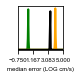

In [35]:
geometry = 'floor'
DOFs = 3
spatvarnoise = False
component = 'Vz'

print('1DOF sphere')
plot_histograms(behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)

/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:14: RuntimeWarning: divide by zero encountered in log
  errs_best = np.log(errs_best)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:15: RuntimeWarning: divide by zero encountered in log
  errs_worst = np.log(errs_worst)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:16: RuntimeWarning: divide by zero encountered in log
  errs_middle = np.log(errs_middle)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


1DOF sphere
best min LOG ERROR -3.4665029252169783
worst max LOG ERROR 3.5932316339374366
effect size (D) best to middle -1.4772843191105616
effect size (D) worst to middle 71.25024342829091


/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:14: RuntimeWarning: divide by zero encountered in log
  errs_best = np.log(errs_best)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:15: RuntimeWarning: divide by zero encountered in log
  errs_worst = np.log(errs_worst)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:16: RuntimeWarning: divide by zero encountered in log
  errs_middle = np.log(errs_middle)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


3DOF sphere
best min LOG ERROR -3.476079763515743
worst max LOG ERROR 6.345787941500286
effect size (D) best to middle -53.133462812853665
effect size (D) worst to middle 95.11058009573075


/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:14: RuntimeWarning: divide by zero encountered in log
  errs_best = np.log(errs_best)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:15: RuntimeWarning: divide by zero encountered in log
  errs_worst = np.log(errs_worst)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:16: RuntimeWarning: divide by zero encountered in log
  errs_middle = np.log(errs_middle)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


3DOF sphere - spatially varying noise
best min LOG ERROR -7.522549302006845
worst max LOG ERROR 5.663733099176424
effect size (D) best to middle -146.4054485456133
effect size (D) worst to middle 101.08006770890209


/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:14: RuntimeWarning: divide by zero encountered in log
  errs_best = np.log(errs_best)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:15: RuntimeWarning: divide by zero encountered in log
  errs_worst = np.log(errs_worst)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:16: RuntimeWarning: divide by zero encountered in log
  errs_middle = np.log(errs_middle)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


3DOF floor - Vz
best min LOG ERROR -3.4950223135085334
worst max LOG ERROR 4.588374433099032
effect size (D) best to middle -87.31810518901587
effect size (D) worst to middle 20.774084914114145


/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:14: RuntimeWarning: divide by zero encountered in log
  errs_best = np.log(errs_best)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:15: RuntimeWarning: divide by zero encountered in log
  errs_worst = np.log(errs_worst)
/var/folders/vr/1mzynlbd42dfym77k97z2srm0000gn/T/ipykernel_85245/3131702096.py:16: RuntimeWarning: divide by zero encountered in log
  errs_middle = np.log(errs_middle)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


3DOF floor - heading
best min LOG ERROR -3.2022134334742614
worst max LOG ERROR 5.159038492371087
effect size (D) best to middle -101.22738195916922
effect size (D) worst to middle 3.2924292321915214


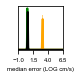

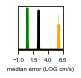

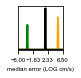

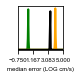

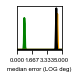

In [36]:
# 1DOF sphere
geometry = 'sphere'
DOFs = 1
spatvarnoise = False
component = 'Vz'

print('1DOF sphere')
plot_histograms(behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)

# 3DOF sphere
geometry = 'sphere'
DOFs = 3
spatvarnoise = False
component = 'Vz'

print('3DOF sphere')
plot_histograms(behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)

# 3DOF sphere - spatially varying noise
geometry = 'sphere'
DOFs = 3
spatvarnoise = True
component = 'Vz'

print('3DOF sphere - spatially varying noise')
plot_histograms(behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)

# 3DOF floor
geometry = 'floor'
DOFs = 3
spatvarnoise = False
component = 'Vz'

print('3DOF floor - Vz')
plot_histograms(behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)

component = 'heading'
print('3DOF floor - heading')
plot_histograms(behaviorDOFs=DOFs,geometry=geometry,spatvarnoise=spatvarnoise,component=component)